In [1]:
"""
Use one cut on 7 qubit GHZ state to get the noisy expval
"""

'\nUse one cut on 7 qubit GHZ state to get the noisy expval\n'

In [2]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2, SamplerV2

from circuit_knitting.cutting import (
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)

from circuit_knitting.cutting.instructions import CutWire
from circuit_knitting.cutting import cut_wires, expand_observables

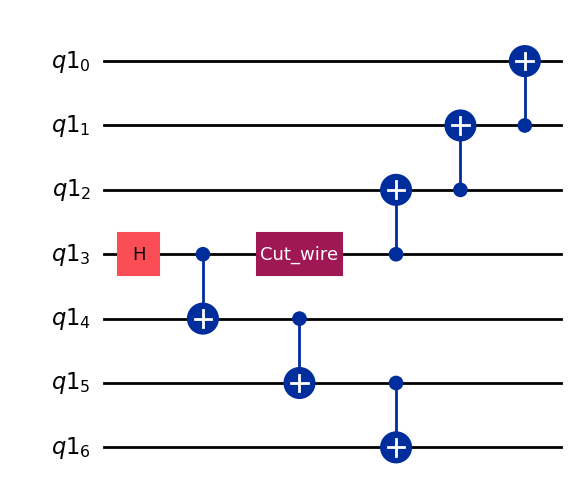

In [3]:
qc = QuantumCircuit(7)
num_qubit=7
qr=QuantumRegister(num_qubit)
cr2=ClassicalRegister(num_qubit,name="cr2")                     
qc=QuantumCircuit(qr)
qc.h(3)
qc.cx(3,4)
qc.append(CutWire(), [3])
qc.cx(3,2)

qc.cx(4,5)


qc.cx(2,1)
qc.cx(1,0)
qc.cx(5,6)
qc.draw("mpl")

In [4]:
#observable = SparsePauliOp(["ZIIIIII"])
observables=[]
coeffs=[]
num_qubit=7
for i in range(num_qubit):
    obs='I'*(i)+ 'Z'+ 'I'*(num_qubit-i-1)
    observables.append(obs)
    coeffs.append(1/num_qubit)
observable = SparsePauliOp(observables, coeffs=coeffs)
observable

SparsePauliOp(['ZIIIIII', 'IZIIIII', 'IIZIIII', 'IIIZIII', 'IIIIZII', 'IIIIIZI', 'IIIIIIZ'],
              coeffs=[0.14285714+0.j, 0.14285714+0.j, 0.14285714+0.j, 0.14285714+0.j,
 0.14285714+0.j, 0.14285714+0.j, 0.14285714+0.j])

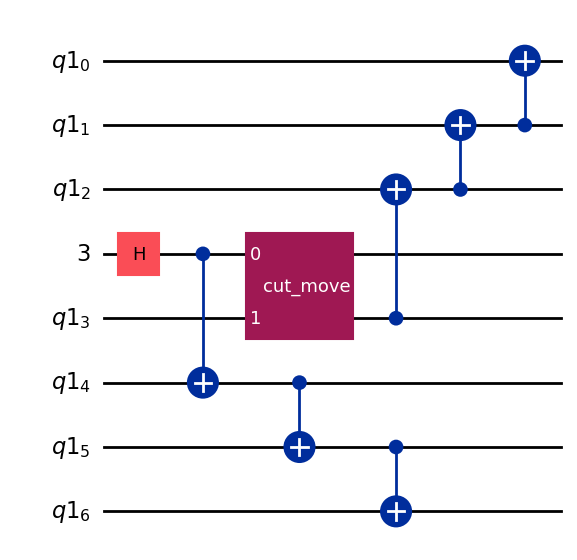

In [5]:
qc_1 = cut_wires(qc)
qc_1.draw("mpl")

In [6]:
observable_expanded_paulis = expand_observables(observable.paulis, qc, qc_1)
observable_expanded_paulis

PauliList(['ZIIIIIII', 'IZIIIIII', 'IIZIIIII', 'IIIZIIII', 'IIIIIZII',
           'IIIIIIZI', 'IIIIIIIZ'])

In [7]:
partitioned_problem = partition_problem(
    circuit=qc_1, observables=observable_expanded_paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables

In [8]:
subobservables

{0: PauliList(['IIII', 'IIII', 'IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ']),
 1: PauliList(['ZIII', 'IZII', 'IIZI', 'IIII', 'IIII', 'IIII', 'IIII'])}

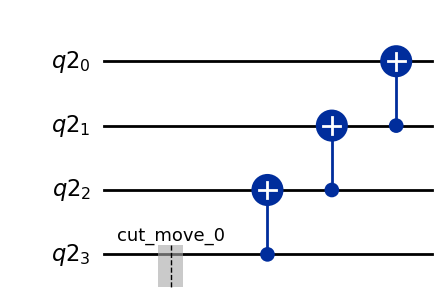

In [9]:
subcircuits[0].draw("mpl")

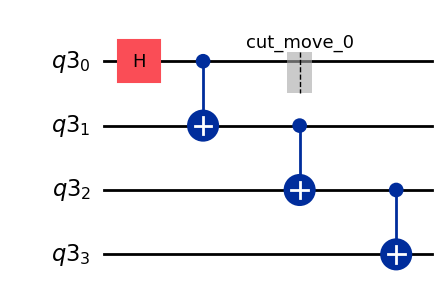

In [10]:
subcircuits[1].draw("mpl")

In [11]:
from qiskit.transpiler.passes import RemoveBarriers
rb=RemoveBarriers()
subcircuits[1]=rb(subcircuits[1])
subcircuits[0]=rb(subcircuits[0])

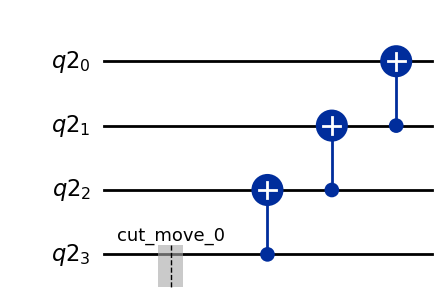

In [12]:
subcircuits[0].draw("mpl")

In [13]:
subcircuits[0].depth()

3

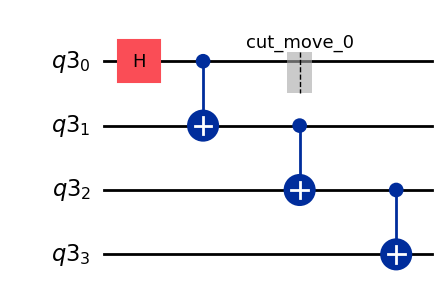

In [14]:
subcircuits[1].draw("mpl")

In [15]:
subcircuits[1].depth()

4

In [16]:
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits,
    observables=subobservables,
    num_samples=np.inf,
)

In [17]:
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
service = QiskitRuntimeService()
real_backend = service.backend("ibm_brisbane")
aer = AerSimulator.from_backend(real_backend)
pm = generate_preset_pass_manager(backend=aer, optimization_level=2)
transpiled_subexperiments={
    label: pm.run(subexperiment)
    for label, subexperiment in subexperiments.items()
}


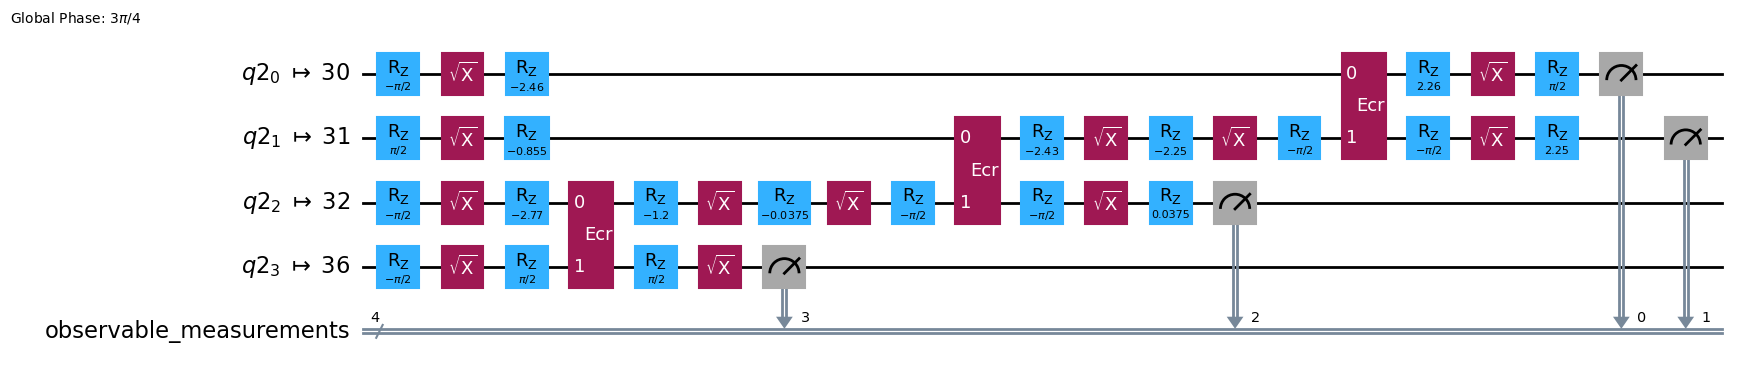

In [18]:
transpiled_subexperiments[0][0].draw("mpl",idle_wires=False)

In [19]:
transpiled_subexperiments[0][0].depth()

20

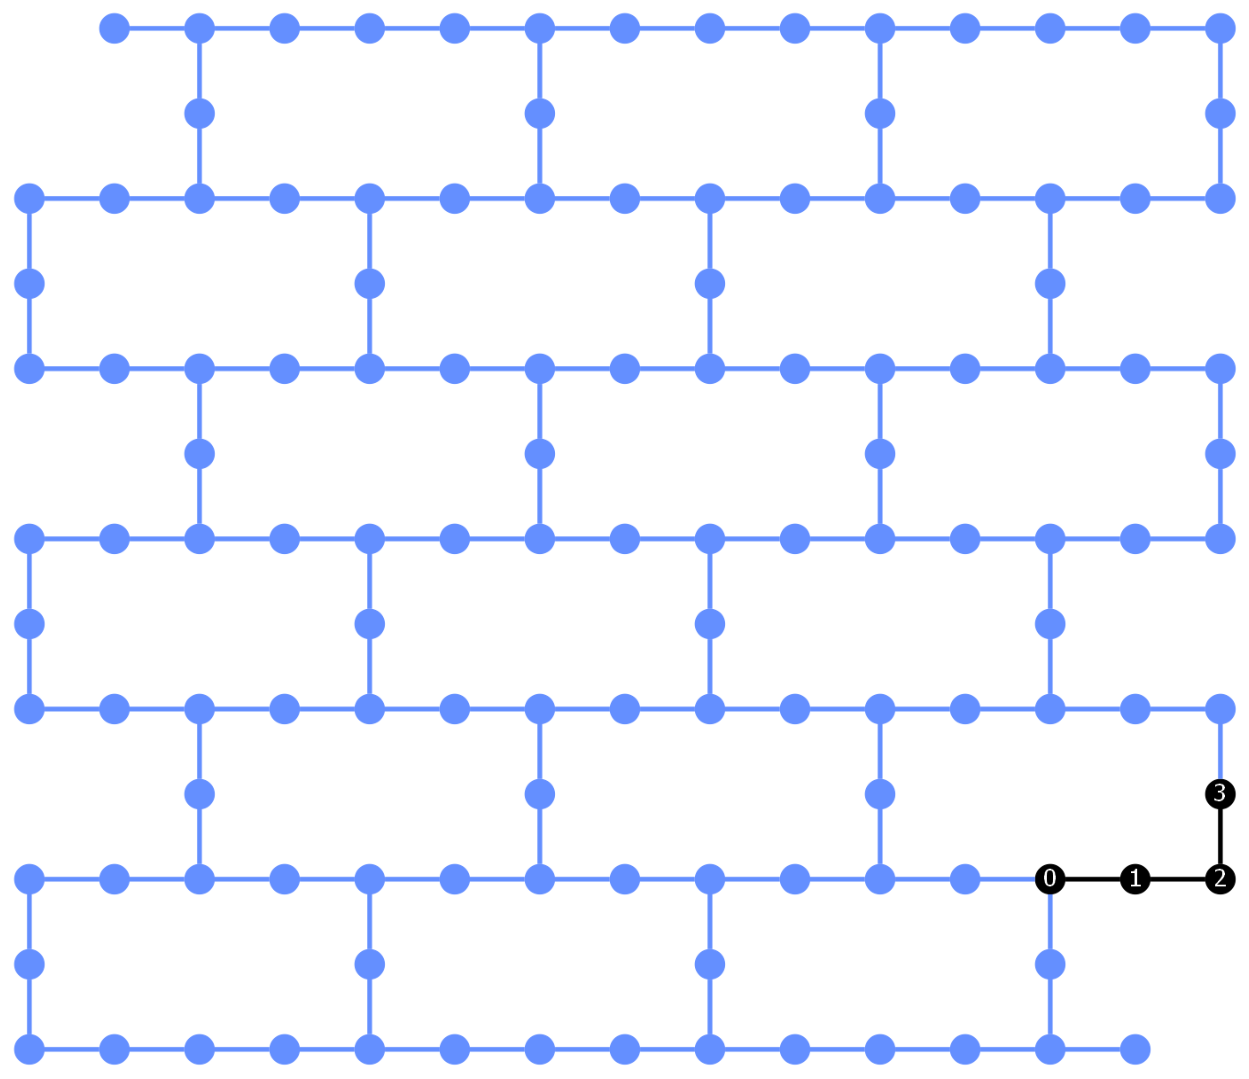

In [20]:
from qiskit.visualization import plot_circuit_layout
plot_circuit_layout(transpiled_subexperiments[0][0], aer)

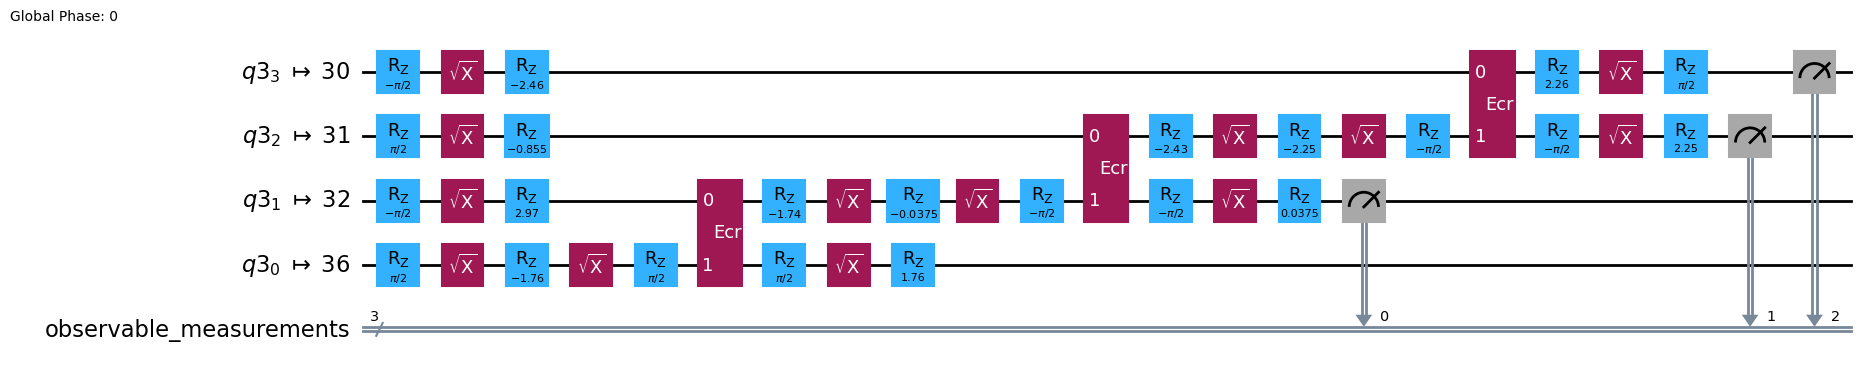

In [21]:
transpiled_subexperiments[1][0].draw("mpl",idle_wires=False)

In [22]:
transpiled_subexperiments[1][0].depth()

22

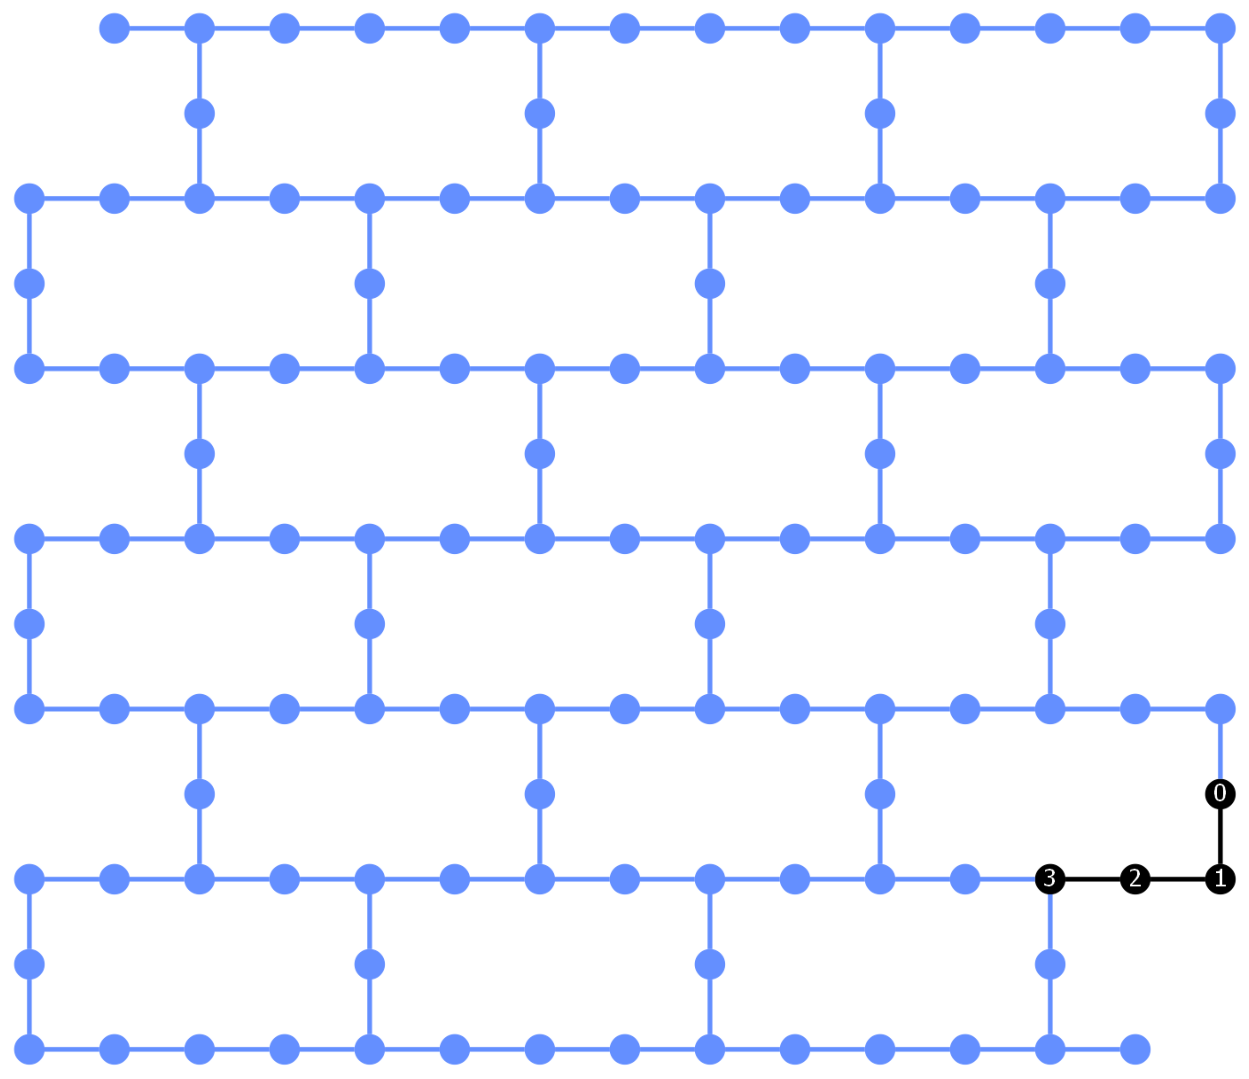

In [23]:
plot_circuit_layout(transpiled_subexperiments[1][0], aer)

In [24]:
sampler = Sampler(backend=aer)

results = {
    label: sampler.run(subexperiment, shots=2**12).result()
    for label, subexperiment in transpiled_subexperiments.items()
}

In [25]:
reconstructed_expvals = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
final_expval = np.dot(reconstructed_expvals, observable.coeffs)

In [26]:
estimator = EstimatorV2()
exact_expval = (
    estimator.run([(qc.decompose("cut_wire"), observable)]).result()[0].data.evs
)
print(f"Reconstructed expectation value: {np.real(np.round(final_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(final_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((final_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: -0.00029114
Exact expectation value: 0.0
Error in estimation: -0.00029114
Relative error in estimation: -inf


C:\Users\shikh\AppData\Local\Temp\ipykernel_25048\1330935100.py:9: RuntimeWarning: divide by zero encountered in divide
  f"Relative error in estimation: {np.real(np.round((final_expval-exact_expval) / exact_expval, 8))}"
C:\Users\shikh\AppData\Local\Temp\ipykernel_25048\1330935100.py:9: RuntimeWarning: invalid value encountered in divide
  f"Relative error in estimation: {np.real(np.round((final_expval-exact_expval) / exact_expval, 8))}"


In [27]:
import json
depth_list=[]
depth_list.append([exp.depth() for exp in transpiled_subexperiments[0]])
depth_list.append([exp.depth() for exp in transpiled_subexperiments[1]])
with open("25 Aug whether cut unroll combined then cut is useful.json", "r") as jsonfile:
    data1 = json.load(jsonfile)

new_data1 = { "experiment 2":{"name": "18 Aug short depth GHZ state 1 cut noisy exp value  ",
    "obtained expectation value" : np.real(np.round(final_expval, 8)),"depth":depth_list},

    
}

    

data1.update(new_data1)

with open("25 Aug whether cut unroll combined then cut is useful.json", "w") as jsonfile:
    json.dump(data1, jsonfile)